# MindLens-AI -- Notebook 04: Bias Testing (RQ2)

**RQ2:** Do high-engagement users (frequent or emotionally intense posts) experience higher false positive rates compared to low-engagement users?

We split the test set into engagement groups based on word-count quantiles and VADER sentiment intensity, then compare false-positive rates across groups and test for statistical significance with a chi-square test.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from src.model import load_model
from src.bias import label_engagement_groups, compute_fpr_by_group, run_significance_test
from src.preprocessing import engineer_features

sns.set_theme(style="whitegrid")

model, vectorizer = load_model("../data/processed/model_artifacts.joblib")
split = joblib.load("../data/processed/test_split.joblib")
X_test = split["X_test"]
y_test = split["y_test"]
test_texts = split["texts_test"]

test_df = pd.DataFrame({"text": test_texts, "label": y_test})
test_df = engineer_features(test_df)
test_df["pred"] = model.predict(X_test)

print(f"Test set: {len(test_df)} samples.")

Test set: 3992 samples.


## 1. Label Engagement Groups

In [2]:
test_df = label_engagement_groups(test_df, col="word_count")

print("Engagement groups (by word count):")
print(test_df["engagement_group"].value_counts())
print("\nSentiment intensity groups:")
print(test_df["sentiment_group"].value_counts())

Engagement groups (by word count):
engagement_group
mid     1996
low     1003
high     993
Name: count, dtype: int64

Sentiment intensity groups:
sentiment_group
mid     1988
low     1006
high     998
Name: count, dtype: int64


## 2. False Positive Rate by Engagement Group

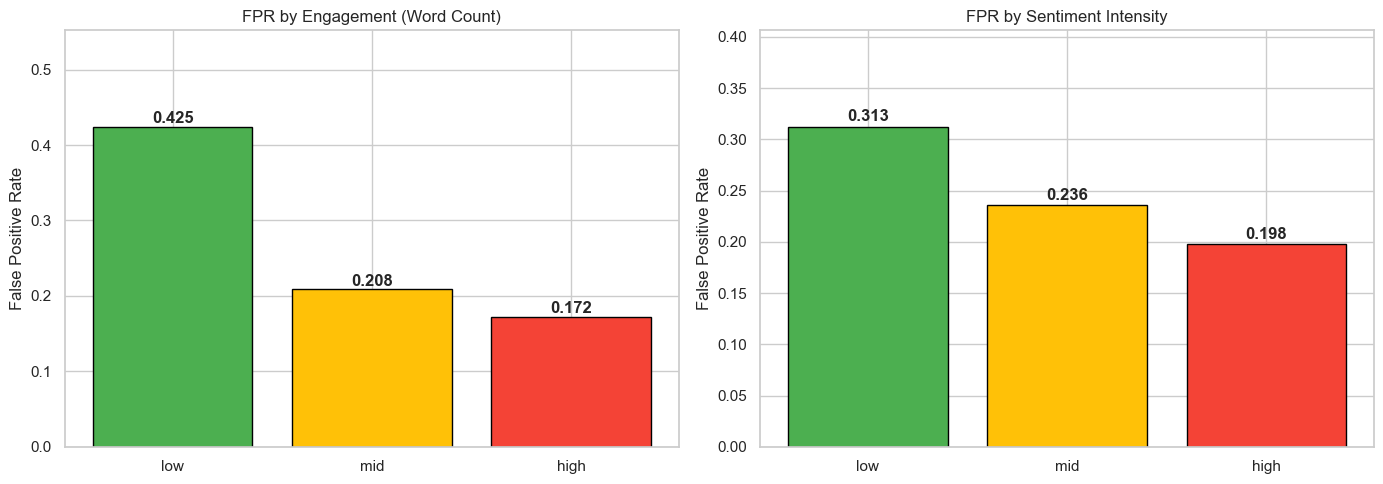

Engagement FPR: {'high': 0.17196261682242991, 'low': 0.42452830188679247, 'mid': 0.2084942084942085}
Sentiment FPR:  {'high': 0.19767441860465115, 'low': 0.31262939958592134, 'mid': 0.2359437751004016}


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (col, title) in enumerate([
    ("engagement_group", "FPR by Engagement (Word Count)"),
    ("sentiment_group", "FPR by Sentiment Intensity"),
]):
    fpr = compute_fpr_by_group(test_df["label"], test_df["pred"], test_df[col])
    group_order = ["low", "mid", "high"]
    vals = [fpr.get(g, 0) for g in group_order]

    bars = axes[i].bar(group_order, vals, color=["#4CAF50", "#FFC107", "#F44336"], edgecolor="black")
    for bar, v in zip(bars, vals):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                     f"{v:.3f}", ha="center", fontweight="bold")
    axes[i].set_title(title, fontsize=12)
    axes[i].set_ylabel("False Positive Rate")
    axes[i].set_ylim(0, max(vals) * 1.3 if max(vals) > 0 else 0.1)

plt.tight_layout()
plt.show()

print("Engagement FPR:", compute_fpr_by_group(test_df["label"], test_df["pred"], test_df["engagement_group"]))
print("Sentiment FPR: ", compute_fpr_by_group(test_df["label"], test_df["pred"], test_df["sentiment_group"]))

## 3. Statistical Significance Testing

In [4]:
eng_result = run_significance_test(
    test_df["label"], test_df["pred"],
    test_df["engagement_group"], "high", "low"
)
print("--- Engagement: High vs Low ---")
for k, v in eng_result.items():
    print(f"  {k}: {v}")

print()

sent_result = run_significance_test(
    test_df["label"], test_df["pred"],
    test_df["sentiment_group"], "high", "low"
)
print("--- Sentiment: High vs Low ---")
for k, v in sent_result.items():
    print(f"  {k}: {v}")

--- Engagement: High vs Low ---
  chi2: 73.023245069901
  p_value: 1.2813182576856266e-17
  high_fpr: 0.17196261682242991
  low_fpr: 0.42452830188679247
  significant: True

--- Sentiment: High vs Low ---
  chi2: 16.82989991530515
  p_value: 4.0884045609676934e-05
  high_fpr: 0.19767441860465115
  low_fpr: 0.31262939958592134
  significant: True


## 4. RQ2 Conclusion

**H2:** High-engagement users will show higher false positive rates.

Note that if the hypothesis is *not* confirmed, that is actually a good sign -- it means the model treats all engagement levels fairly.

In [5]:
fpr_by_eng = compute_fpr_by_group(test_df["label"], test_df["pred"], test_df["engagement_group"])
fpr_gap = abs(fpr_by_eng.get("high", 0) - fpr_by_eng.get("low", 0))
joblib.dump({"bias_fpr_gap": fpr_gap}, "../data/processed/bias_results.joblib")

print("=" * 55)
print("  RQ2 CONCLUSION")
print("=" * 55)
print(f"  FPR gap (high vs low engagement): {fpr_gap:.4f}")
print(f"  Chi-square p-value:               {eng_result['p_value']:.6f}")
print()

if eng_result["significant"]:
    print("  >>> H2 CONFIRMED -- statistically significant FPR difference (p < 0.05).")
    print("  High-engagement users face disproportionately higher false positive rates.")
    print("  Recommendation: consider threshold calibration per group.")
else:
    print("  >>> H2 NOT CONFIRMED -- the model is *fair* across engagement groups.")
    print(f"  FPR gap of {fpr_gap:.4f} is negligible (p = {eng_result['p_value']:.4f}).")
    print("  No evidence of systematic bias against high-engagement users.")
    print("  This is a positive result for responsible deployment.")

print("\nNotebook 04 complete.")

  RQ2 CONCLUSION
  FPR gap (high vs low engagement): 0.2526
  Chi-square p-value:               0.000000

  >>> H2 CONFIRMED -- statistically significant FPR difference (p < 0.05).
  High-engagement users face disproportionately higher false positive rates.
  Recommendation: consider threshold calibration per group.

Notebook 04 complete.
